## 

## Workshop Day 2

In [2]:
# Dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from util import *

import tensorflow as tf
from tensorflow.keras import datasets, layers, models


# Part 1: Extract data 
Extracting data from  Camargo Dataset

In [3]:
#TODO

Extract data of person walking with exoskeleton. 
For the purpose of this second experiment we will only observe Walking (both in transparent mode and in State Machine mode). 

We create two different df, one for SM one for transparent

In [3]:
subject_path = "../data/AB80_ml_dataset_extracted.csv"
# Read the CSV file into a DataFrame
df = pd.read_csv(subject_path)

FREQUENCY_DATA= 333 

df_Transparent = df[df['condition'] == 'transparent_WALKING']
df_StateMachine = df[df['condition'] == 'SM_WALKING']


In [23]:
# transparent
stance_interpol = df_Transparent[' StanceInterpolationFactor'].to_numpy()
joint_1 = df_Transparent[' JointPositions_1'].to_numpy()
joint_2 = df_Transparent[' JointPositions_2'].to_numpy()
joint_3 = df_Transparent[' JointPositions_3'].to_numpy()
joint_4 = df_Transparent[' JointPositions_4'].to_numpy()

segmented_joints_transparent ={0:[], 1: [], 2:[], 3:[]}
segmented_alpha_transparent, segmented_joints_transparent[0] = segment_stride(stance_interpol, joint_1)
_, segmented_joints_transparent[1] = segment_stride(stance_interpol, joint_2)
_, segmented_joints_transparent[2] = segment_stride(stance_interpol, joint_3)
_, segmented_joints_transparent[3] = segment_stride(stance_interpol, joint_4)

print("Segmented alpha transparent shape ",segmented_alpha_transparent.shape)
print("Segmented joint 1 transparent shape ", segmented_joints_transparent[0].shape)
print("Segmented joint 2 transparent shape ",segmented_joints_transparent[1].shape)
print("Segmented joint 3 transparent shape ",segmented_joints_transparent[2].shape)
print("Segmented joint 4 transparent shape ",segmented_joints_transparent[3].shape)

# State Machine 
stance_interpol = df_StateMachine[' StanceInterpolationFactor'].to_numpy()
joint_1 = df_StateMachine[' JointPositions_1'].to_numpy()
joint_2 = df_StateMachine[' JointPositions_2'].to_numpy()
joint_3 = df_StateMachine[' JointPositions_3'].to_numpy()
joint_4 = df_StateMachine[' JointPositions_4'].to_numpy()

segmented_joints_SM= {0:[], 1: [], 2:[], 3:[]}
segmented_alpha_SM, segmented_joints_SM[0] = segment_stride(stance_interpol, joint_1)
_, segmented_joints_SM[1] = segment_stride(stance_interpol, joint_2)
_, segmented_joints_SM[2] = segment_stride(stance_interpol, joint_3)
_, segmented_joints_SM[3] = segment_stride(stance_interpol, joint_4)

print("Segmented alpha state machine shape ",segmented_alpha_SM.shape)
print("Segmented joint 1 state machine shape ", segmented_joints_SM[0].shape)
print("Segmented joint 2 state machine shape ",segmented_joints_SM[1].shape)
print("Segmented joint 3 state machine shape ",segmented_joints_SM[2].shape)
print("Segmented joint 4 state machine shape ",segmented_joints_SM[3].shape)

N_STEPS_TRANSPARENT = segmented_alpha_SM.shape[0]

Segmented alpha transparent shape  (34, 100)
Segmented joint 1 transparent shape  (34, 100)
Segmented joint 2 transparent shape  (34, 100)
Segmented joint 3 transparent shape  (34, 100)
Segmented joint 4 transparent shape  (34, 100)
Segmented alpha state machine shape  (34, 100)
Segmented joint 1 state machine shape  (34, 100)
Segmented joint 2 state machine shape  (34, 100)
Segmented joint 3 state machine shape  (34, 100)
Segmented joint 4 state machine shape  (34, 100)


Plot steps (with mean and variance)

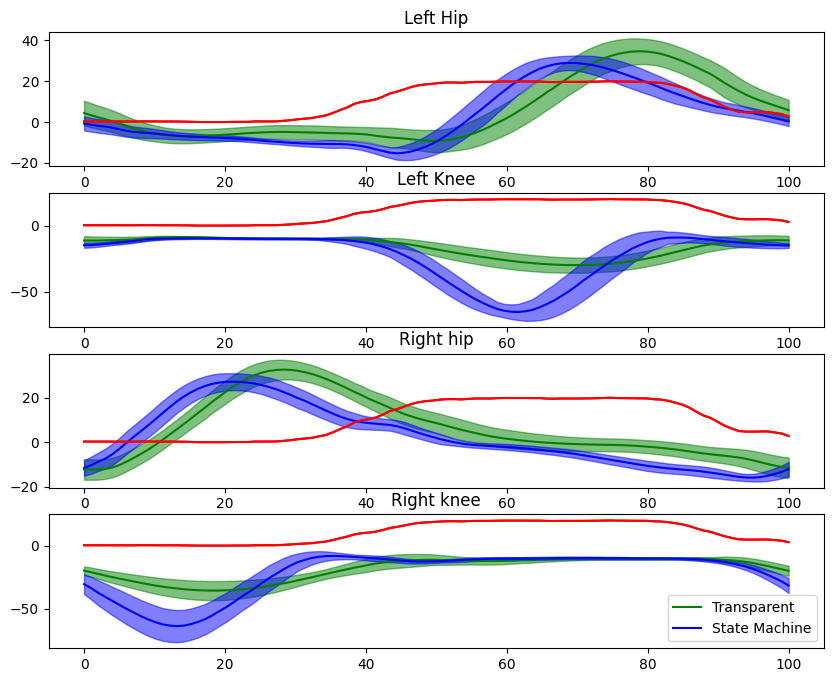

In [5]:
fig, axs = plt.subplots(4, figsize=(10, 8))
axs[0].set_title('Left Hip')
axs[1].set_title('Left Knee')
axs[2].set_title('Right hip')
axs[3].set_title('Right knee')

#transparent
for i in range(4):
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_joints_transparent[i], 0)*180/np.pi, 'g-', label= "Transparent")
    axs[i].fill_between(np.linspace(0, 100, 100), 
                        (np.mean(segmented_joints_transparent[i], 0)- np.std(segmented_joints_transparent[i], 0))*180/np.pi,
                        (np.mean(segmented_joints_transparent[i], 0) + np.std(segmented_joints_transparent[i], 0))*180/np.pi, color='g', alpha=0.5)
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_alpha_transparent, 0)*20, 'r-')

    # STate machine
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_joints_SM[i], 0)*180/np.pi, 'b-', label= "State Machine")
    axs[i].fill_between(np.linspace(0, 100, 100), 
                        (np.mean(segmented_joints_SM[i], 0)- np.std(segmented_joints_SM[i], 0))*180/np.pi,
                        (np.mean(segmented_joints_SM[i], 0) + np.std(segmented_joints_SM[i], 0))*180/np.pi, color='b', alpha=0.5)
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_alpha_transparent, 0)*20, 'r-')

plt.legend()
plt.show()

# Part 2: Regression of the gait phase


**Exercice 2** Build Neural Network that receives as input the kinematics and the stance interpolation factor and returns as output the gait phase (x coordidinate previous plot)

We will build two different NN as in *Paper*: CNN and LSTM. (Similar structure but different input in this exercice)




# CNN

**Inputs:** The model had a data input size of 10 channel values (joint position/velocity) for every time step of 5 ms with a window size of 80 data samples. 

Prepare input:

In [37]:
# concatenate joint angles and steps
input_transparent= np.array([np.concatenate(segmented_joints_transparent[0], 0), 
                    np.concatenate(segmented_joints_transparent[1], 0), 
                    np.concatenate(segmented_joints_transparent[2], 0), 
                    np.concatenate(segmented_joints_transparent[3], 0)])
# concatenate to input the joint velocity
joint_velocity = np.array([np.gradient(np.concatenate(segmented_joints_transparent[0], 0)), 
                    np.gradient(np.concatenate(segmented_joints_transparent[1], 0)), 
                    np.gradient(np.concatenate(segmented_joints_transparent[2], 0)), 
                    np.gradient(np.concatenate(segmented_joints_transparent[3], 0))])
input_transparent = np.concatenate((input_transparent, joint_velocity), 0)

# normalize input data
mean= np.mean(input_transparent, 1)[:, np.newaxis]
std = np.std(input_transparent, 1)[:, np.newaxis]
input_transparent= (input_transparent - mean) / std
print("Input Shape ", input_transparent.shape)

Input Shape  (8, 3400)


Prepare Output

In [51]:
output_transparent = np.tile(np.linspace(0, 1, 100), N_STEPS_TRANSPARENT) # created normalized
print("Output shape ", output_transparent.shape)

Output shape  (3400,)


Divide data in time windows

In [52]:
def divide_time_windows(input, output, window_length, step):
    divided_input = []
    divided_output = []
    for i in range(window_length, input.shape[1], step):
        divided_input.append(input[:, i-window_length: i])
        divided_output.append(output[i])
    
    return np.array(divided_input), np.array(divided_output)

In [53]:
WINDOW_LENGTH = 80
STEP = 10
input_transparent, output_transparent = divide_time_windows(input_transparent, output_transparent, WINDOW_LENGTH, STEP)
print("Data Shape: ", input_transparent.shape, output_transparent.shape)

Data Shape:  (332, 8, 80) (332,)


Divide training set and output set in training and validation set (first 70% of steps in training, 30% val set). 

In [54]:
train_input_transparent = input_transparent[:int(N_STEPS_TRANSPARENT*0.7*10), :, :]
train_output_transparent = output_transparent[:int(N_STEPS_TRANSPARENT*0.7*10)]
val_input_transparent = input_transparent[int(N_STEPS_TRANSPARENT*0.7*10):, :, :]
val_output_transparent = output_transparent[int(N_STEPS_TRANSPARENT*0.7*10):]

print("Training set shape: ", train_input_transparent.shape, train_output_transparent.shape)
print("Validation set shape: ", val_input_transparent.shape, val_output_transparent.shape)

Training set shape:  (237, 8, 80) (237,)
Validation set shape:  (95, 8, 80) (95,)


**Create Model:** 

**Loss function:** To ensure that the gait phase error was evaluated accurately during the transition from one gait cycle to the next, where 100 and 0 represent the same value, we used an angular similarity metric by computing the cosine distance between the predicted and the ground truth Cartesian coordinates. The root mean square error (RMSE) of each stride was then computed as the percentage representation of the root mean square of the angular similarity
metric over the gait cycle.


**Training:** The CNN was trained using a stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 and a batch size of 128, iterating over a maximum of 200 epochs

# Part 3: Test on robot